# Models Comparison for TinyML

In [41]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.utils.multiclass import unique_labels

import tensorflow
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sefr import SEFR

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import m2cgen as m2c
from micromlgen import port

In [42]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.set_random_seed(RANDOM_SEED)

In [43]:
with open('../data/X_paper.pkl', 'rb') as f:
    X = pickle.load(f)

with open('../data/y_paper.pkl', 'rb') as f:
    y = pickle.load(f)

In [44]:
"""X = pd.DataFrame(X)
y = pd.DataFrame(y)"""

'X = pd.DataFrame(X)\ny = pd.DataFrame(y)'

In [45]:
X

array([[  22,  110,  101,  222,    0],
       [  21,  102,  100,  220,    0],
       [  21,  102,  100,  212,    0],
       ...,
       [ 111,  122,  112, 1120,    0],
       [ 111,  122,  112, 1120,    0],
       [ 111,  122,  112, 1112,    0]])

In [46]:
X = np.concatenate((X[:250], X[750:1000], X[1500:]), axis=0)
y = np.concatenate((y[:250], y[750:1000], y[1500:]), axis=0)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

C:\Users\luigi.borriello2\.conda\envs\ts\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
C:\Users\luigi.borriello2\.conda\envs\ts\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review 

## Model Spotting

In [48]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'


In [49]:
y_train

array([5, 1, 4, 4, 5, 4, 5, 1, 4, 0, 5, 1, 4, 0, 4, 0, 4, 4, 1, 0, 0, 4,
       0, 4, 0, 0, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 1,
       5, 5, 0, 4, 1, 4, 5, 1, 0, 0, 1, 4, 0, 4, 0, 4, 1, 1, 1, 4, 1, 0,
       4, 0, 4, 4, 4, 4, 4, 0, 0, 4, 4, 5, 0, 5, 4, 0, 4, 4, 1, 0, 0, 5,
       0, 4, 4, 4, 4, 5, 4, 1, 1, 1, 5, 0, 1, 4, 1, 1, 4, 1, 4, 4, 4, 0,
       5, 4, 4, 4, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 4, 4, 4, 1, 4, 0, 1, 4,
       5, 1, 0, 0, 5, 0, 1, 4, 0, 4, 1, 4, 4, 0, 1, 4, 4, 4, 0, 5, 4, 0,
       0, 0, 0, 0, 4, 0, 0, 4, 4, 0, 4, 0, 4, 4, 4, 5, 0, 0, 5, 1, 4, 5,
       0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 4, 4, 5, 4, 0, 0, 4, 4, 0, 0, 0, 4,
       1, 4, 1, 5, 0, 4, 5, 0, 4, 1, 4, 1, 4, 4, 4, 1, 5, 0, 5, 0, 1, 0,
       4, 4, 5, 4, 0, 4, 0, 4, 1, 4, 4, 0, 1, 0, 5, 4, 5, 4, 4, 4, 4, 0,
       0, 0, 4, 4, 1, 1, 0, 0, 4, 0, 4, 1, 0, 1, 5, 5, 4, 4, 4, 4, 0, 1,
       4, 1, 4, 5, 4, 1, 0, 1, 4, 0, 1, 0, 4, 4, 5, 4, 1, 1, 4, 4, 4, 0,
       1, 1, 4, 4, 0, 1, 4, 1, 1, 1, 0, 0, 1, 4, 4,

In [50]:
# Spot-Check Algorithms
models = []
'''
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma='auto', random_state=seed)))
models.append(('RF',  RandomForestClassifier(random_state=seed, n_estimators = 50)))
models.append(('ET',  ExtraTreesClassifier(random_state=seed, n_estimators = 50)))
'''
#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression(random_state=seed))])))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.5, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [51]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

C:\Users\luigi.borriello2\.conda\envs\ts\lib\site-packages\sklearn\model_selection\_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
C:\Users\luigi.borriello2\.conda\envs\ts\lib\site-packages\sklearn\model_selection\_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the 

GNB - 0,52 0,08
LR - 0,51 0,06
CART - 0,75 0,05
SVC - 0,74 0,03


C:\Users\luigi.borriello2\.conda\envs\ts\lib\site-packages\sklearn\tree\tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\luigi.borriello2\.conda\envs\ts\lib\site-packages\sklearn\tree\tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to rev

C:\Users\luigi.borriello2\.conda\envs\ts\lib\site-packages\sklearn\tree\tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\luigi.borriello2\.conda\envs\ts\lib\site-packages\sklearn\tree\tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to rev

RF - 0,76 0,05


C:\Users\luigi.borriello2\.conda\envs\ts\lib\site-packages\sklearn\tree\tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\luigi.borriello2\.conda\envs\ts\lib\site-packages\sklearn\tree\tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to rev

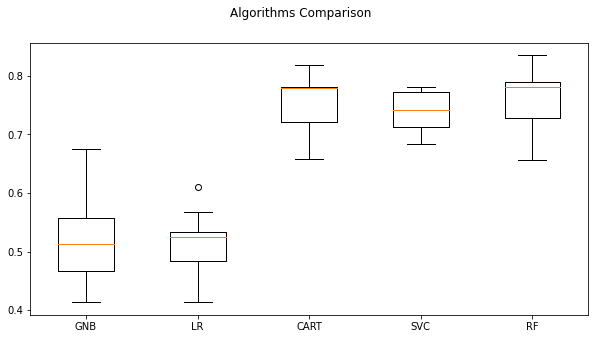

In [52]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

# Export Models in C code

In [53]:
modelsInPipeline = []
modelsInPipeline.append('LR')
modelsInPipeline.append('SFR')

In [54]:
for name, model in models:
    prepath = 'exportedModels/'
    path = prepath + name + '.h'
    if name in modelsInPipeline:
        model = model[1]
    with open(path, 'w') as f:
        f.write(port(model))